 # Working Notebook

 This is a notebook to keep an up-to-date working version of the project.

In [1]:
# Import required modules
from myModule import *


In [2]:
# Import PAIPR-generated data
PAIPR_dir = ROOT_DIR.joinpath('data/gamma_20111109')
data_0 = import_PAIPR(PAIPR_dir)


In [3]:
# 
accum_long = format_PAIPR(data_0, start_yr=1979, end_yr=2009)
traces = accum_long.groupby('trace_ID')

# New accum and std dfs in wide format
accum = accum_long.pivot(
    index='trace_ID', columns='Year', values='accum')
accum_std = accum_long.pivot(
    index='trace_ID', columns='Year', values='std')

# Create df for mean annual accumulation
accum_mu = traces.aggregate(np.mean).drop('Year', axis=1)
accum_mu = gpd.GeoDataFrame(
    accum_mu, geometry=gpd.points_from_xy(
        accum_mu.Lon, accum_mu.Lat)
).drop(['Lat', 'Lon', 'elev'], axis=1)
accum_mu.crs = "EPSG:4326"

# Create a gdf from accum df
accum_gdf = gpd.GeoDataFrame(
    accum, geometry=gpd.points_from_xy(
        traces.aggregate(np.mean)['Lon'], 
        traces.aggregate(np.mean)['Lat'])
)
accum_gdf.crs = "EPSG:4326"



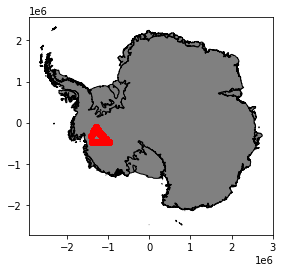

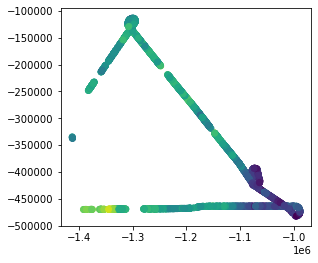

In [4]:
# Import Antarctic outline shapefile
ant_path = ROOT_DIR.joinpath(
    'data/Ant_basemap/Coastline_medium_res_polygon.shp')
ant_outline = gpd.read_file(ant_path)

# Convert accum crs to same as Antarctic outline
accum_gdf = accum_gdf.to_crs(ant_outline.crs)
accum_mu = accum_mu.to_crs(ant_outline.crs)

# Plot inset map
base = ant_outline.plot(color='grey', edgecolor='black')
accum_gdf.sample(n=1000).plot(ax=base, color='red')

# Plot mean accumulation spatial map
accum_mu.sample(n=2500).plot(column='accum')



 We used the below code to find and download required digital surface model data from REMA.
 To save time and to avoid unnecessarily large file uploads for this project, we leave this code commented out and simply load a dataset containing the necessary data at a later point.

In [ ]:

# # Define path to index shapefile
# index_file = ROOT_DIR.joinpath("data/REMA", 
#     "REMA_Tile_Index_Rel1.1", "REMA_Tile_Index_Rel1.1.shp")

# # Import shapefile of DEM tile locations
# dem_index = gpd.read_file(index_file)

# # Keep only DEMs that contain accum traces
# dem_index = (
#     gpd.sjoin(dem_index, accum_mu, op='contains')
#     .iloc[:,0:dem_index.shape[1]]).drop_duplicates()

# # Find and download missing REMA DSM tiles
# REMA_outdir = ROOT_DIR.joinpath("data/REMA/tiles_8m_v1.1")
# tiles_list = pd.DataFrame(
#     dem_index.drop(columns='geometry'))
# # For development purposes, only using first 2 tiles
# # get_REMA(tiles_list, REMA_outdir) 
# get_REMA(tiles_list[:2], REMA_outdir) 


 We next calculate the slope and aspect using the downloaded DSM data.
 We also extract the elevation, slope, and aspect values at each trace location and add these to the dataframe containing the accumulation data.
 Similar to the above step, to avoid large file sizes we performed these calculations previously, and instead load the final product.

In [ ]:

# # Generate list of paths to downloaded DEMs for topo
# #  calculations
# REMA_dir = ROOT_DIR.joinpath("data/REMA/tiles_8m_v1.1")
# dem_list = [path for path in REMA_dir.glob('**/*dem.tif')]

# # Calculate slope and aspect for each DEM
# # For development purposes, only processing first in list
# # [calc_topo(dem) for dem in dem_list]
# [calc_topo(dem) for dem in dem_list[:1]]

# # Extract elevation, slope, and aspect values for each trace 
# # location
# raster_vals = accum_mu.drop(['accum', 'std'], axis=1)
# tif_dirs = [path.parent for path in dem_list[:1]]
# for path in tif_dirs:
#     raster_vals = topo_vals(path, raster_vals)

# # Save raster_vals to GeoJSON
# file_out = ROOT_DIR.joinpath('data/REMA/raster_vals.geojson')
# raster_vals.to_file(file_out, driver='GeoJSON')


 We now load the pre-processed data results generated using the REMA raster data.

In [5]:

raster_vals = gpd.read_file(
    ROOT_DIR.joinpath('data/REMA/raster_vals.geojson'))